In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [3]:
#test
m = nn.Linear(2,3)
in_ = torch.randn(4,2)
out_ = m(in_)

A = torch.tensor([1,2,2])
B = torch.tensor([1]*3)
import numpy as np
np.math.atan(1000)
    

1.5697963271282298

#### How to simulate: $t_{j+1} = \int_{t_{j}}^{\infty} t .f^{*}(t) dt $ where $f^{*}(t) = \exp(at+b +c\exp(dt+e)-c\exp(at+b))$ a,b,c,d and e are randomly selected ?

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrale

In [11]:
#parameters
a,b,c,d,e = np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1)
tj = 0.05


In [12]:
#function
def f(t):
    return np.exp(a*t + b +c * np.exp(d*t + e) - c* np.exp(a*t+b))

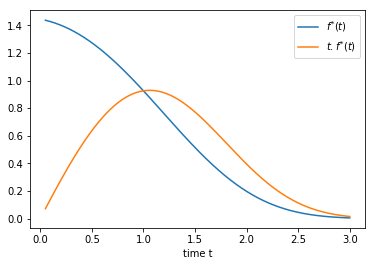

In [13]:
t = np.linspace(tj,3,1000)
ft = f(t)
tft = t*ft
plt.plot(t,ft,label="$f^{*}(t)$")
plt.plot(t,tft,label="$t.f^{*}(t)$")
plt.xlabel("time t")
plt.legend()

#### Conclusion: $ t.f^{*}(t)$ seems to be a continuous and derivable function

#### __1st method:__ Deterministic method: Riemann trapezoidal rule
#### $ \int_{t_{j}}^{\infty} t .f^{*}(t) dt \simeq \int_{t_{j}}^{A} g^{*}(t) dt \simeq \Delta T \sum_{i=0}^{N-1} \frac{g(x_{i}) + g(x_{i+1})}{2} $ where $\Delta T = \frac{A-t_{j}}{N}$

#### We have to estimate $A$. To do so, we say that the best candidate for $A$ verify $  \frac{\int_{t_{j}}^{A} g^{*}(t) - \int_{t_{j}}^{10 A} g^{*}(t)}{\int_{t_{j}}^{A} g^{*}(t)} < 0.05$

In [14]:
N = 10000
#return the value of the trapezoidal method for a given A
def trapezoidal(A):
    DeltaT = (A-tj)/N
    sum_ = 0
    discrete_time = np.array([DeltaT]*(N))
    discrete_time = np.concatenate((np.array([tj]),discrete_time))
    discrete_time = np.cumsum(discrete_time)

    discrete_f = discrete_time*f(discrete_time)
    sum_ = DeltaT * np.sum((discrete_f[1:] + discrete_f[:-1])/2)
    return sum_
A = 5*tj
sum_ = trapezoidal(A)
increment = 0
while(np.abs(trapezoidal(A) - trapezoidal(10*A))/trapezoidal(A) > 0.05 and increment < 1000):
    A = 10*A
    sum_ = trapezoidal(A)
    increment += 1
if(increment == 1000):
    print("The loop has been stopped because the sum doesn't converge")
print("Trapezoidal approximation of the integral:",sum_)

integral = integrale.quad(lambda t:t*f(t),tj,1000)
integral,error = integral
print("scipy result of the integral :", integral)


Trapezoidal approximation of the integral: 1.4289533913638552
scipy result of the integral : 1.4579333444458813


#### __2nd method:__ Integrale by substitution $t = \tan(u)$
#### $\int_{t_{j}}^{\infty} t .f^{*}(t) dt = \int_{ \tan^{-1}(t_{j})}^{\frac{\pi}{2}} \tan(u) .f^{*}(\tan(u)) \frac{1}{\cos^{2}(u)} du$
#### Thus, we don't have to simulate infinity A since the sampling is in a finite interval $[  \tan^{-1}(t_{j})  ,  \frac{\pi}{2} ]$

In [15]:
def h(u):
    return np.tan(u)*f(np.tan(u))*(1+np.tan(u)**2)



In [50]:
DeltaT = (np.pi/2-np.math.atan(tj))/N

discrete_time = np.array([DeltaT]*(N))
discrete_time = np.concatenate((np.array([np.arctan(tj)]),discrete_time))
discrete_time = np.cumsum(discrete_time)

discrete_h = h(discrete_time)
sum_ = DeltaT * np.sum((discrete_h[1:] + discrete_h[:-1])/2)
X = torch.tensor([1,2,3])
X = torch.cat((torch.tensor([0]),X))
X = X[1:] - X[:-1]
X

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([1, 1, 1])

#### Conclusion: Not stable! 

#### __3rd method:__ Using normal distribution
#### $\int_{t_{j}}^{\infty} t .f^{*}(t) dt = \int_{t_{j}}^{\infty} \sqrt{2\pi}.\exp(\frac{t^{2}}{2}). t .f^{*}(t) . \frac{1}{\sqrt{2\pi}}.\exp(-\frac{t^{2}}{2}) dt = \mathrm{E}(G(\mathrm{N})) $ where $N$ has a normal distribution with mean 0 and variance 1

In [17]:
def G(t,tj):
    return (t>tj) * np.sqrt(2*np.pi) * np.exp(t**2 / 2) * t * f(t)
sample = np.random.randn(N) 
sample = G(sample,tj)
print(np.mean(sample))

1.4720608651881684


## Conclusion: comparison of methods 1 and 3

#### Hidden Layer: $h_j = \max{(W^{y}y_{j} + W^{t}t_{j} + W^{h}h_{j-1} + b_{h},0)} $


#### Marker Generation: $P(y_{j+1}=k\mid h_{j}) = \frac{\exp(V_{k,:}^{y}h_{j} + b_{k}^{y})}{\sum_{k=1}^{K} \exp(V_{k,:}^{y}h_{j} + b_{k}^{y})} = \sigma(z)_{k}$ where $\sigma$ is softmax function and $z$ is the vector $ V^{y}h_{j} + b^{y}$ 


#### Conditional Density: $f^{*}(t) = \exp\{{v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} + \frac{1}{w}\exp({v^{t}}^\top.h_{j} + b^{t}) -\frac{1}{w}\exp({v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} )\} $

In [282]:
class Rmtpp(nn.Module):
    
    def __init__(self,marker_dim):
        #marker_dim equals to time_dim
        super(Rmtpp, self).__init__()
        #embedding yj for a more compact and efficient representation
        self.embedding = nn.Linear(1,1)
        #linear transformation
        self.lin_op = nn.Linear(3,1) 
        self.vt = nn.Linear(1,1)
        #weights
        self.w_t = torch.rand(1) 
        self.w = torch.rand(1) 
        self.V_y = torch.rand(marker_dim) #marker dim = number of markers 
        self.b_y = torch.rand(marker_dim) #bias
        
    
    #compute the function fstar
    def fstart(self,t,tj,hj):
        return torch.exp(self.vt(hj) + self.w_t*(t-tj) + 1/self.w * torch.exp(self.vt(hj)) -1/self.w * torch.exp(self.vt(hj) + self.w_t*(t-tj)))
    
    #compute integral of t*fstart(t) for tj to infinity using monteCarlo method
    def numerical_mean(self,tj,hj):
        N = 10000
        samp = torch.randn(N,1)
        sample = torch.sqrt(torch.tensor([2*F.math.pi]*N).unsqueeze(-1)) * torch.exp(1/2 * samp**2) * samp * self.fstart(samp,tj,hj)
        #I select only value greater than tj
        samp = samp.squeeze(1)
        sample = sample.squeeze(1)
        samp = samp>tj
        samp = samp.float()
        sample = torch.dot(samp,sample) 
        #then cumsum of sample 
        return torch.cumsum(sample,dim=0)
        
        
        
    def forward(self, time, marker, hidden_state):
        #I first compute next time
        tj = time
        time = self.numerical_mean(time,hidden_state)
        logfstar = -1 * torch.log(self.fstart(time,tj,hidden_state))
        #Then next marker distribution
        soft_max = nn.Softmax()
        marker_distribution = soft_max(self.V_y*hidden_state + self.b_y)
        logprob = -1 * torch.log(marker_distribution)
        #Finally next hidden_state
        embedding = self.embedding(marker)
        #print(embedding)
        #print(time)
        #print(hidden_state)
        input_ = torch.cat((embedding, time.unsqueeze(-1), hidden_state))
        hidden_state = F.relu(self.lin_op(input_))
         
        return logprob, logfstar, hidden_state
    
    def init_hidden(self):
        return torch.zeros(1)
    
    def log_likelihood(self,log_time_series_list,log_marker_series_list):
        #time series and marker series are output of the RMTPP network
        #return log_likelihood of all sequences
        lll = 0
        for i in range(len(time_series_list)):
            lll += torch.sum(log_time_series_list) + torch.sum(log_marker_series_list)
        return lll       
                
        

## Training:

In [283]:
m = nn.Linear(1, 1)
wt = torch.rand(1)
t = torch.randn(3,1)
tj = torch.rand(1)

#t = t.squeeze(1)

y = torch.randn(3)
y = y.unsqueeze(-1)
z = y*t
z = z.squeeze(1)
a = torch.tensor([1,0,1])
a = a.float()

x= torch.tensor([1])
x
y = torch.tensor([2])

z = torch.tensor(2).unsqueeze(-1)
torch.cat((x,y,z))

tensor([1, 2, 2])

In [285]:
loss = nn.NLLLoss()
learning_rate = 0.0005
rnn = Rmtpp(10)


def train(time,marker):
    loss = 0
    hidden = rnn.init_hidden()
    lp = []
    lf = []
    for j in range(len(time)):
        tj = time[j]
        yj = marker[j]
        #print(tj)
        #print(yj)
        logprob, logfstar, hidden = rnn(tj, yj, hidden)
        lp.append(logprob)
        lf.append(logfstar)
    #loss = rnn.log_likelihood(-1*logfstar,-1*logprob)
    return lp,lf

t = torch.randn(3,1)
m = torch.randn(3,1)
train(t,m)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


([tensor([2.1349, 2.0067, 2.0958, 2.9000, 2.6037, 2.1029, 2.9444, 2.6503, 2.0633,
          2.0962]),
  tensor([   inf,    inf,    inf,    inf, 0.0026,    inf, 5.9372,    inf,    inf,
             inf], grad_fn=<MulBackward>),
  tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], grad_fn=<MulBackward>)],
 [tensor([inf], grad_fn=<MulBackward>),
  tensor([nan], grad_fn=<MulBackward>),
  tensor([nan], grad_fn=<MulBackward>)])